In [4]:
import numpy as np
from tqdm.notebook import tqdm
from crowd_evaluation import OldEvaluator, ConfidenceEvaluatorC
from datasets import SyntheticDataset
import matplotlib.pyplot as plt
from joblib import Memory, Parallel, delayed
memory = memory = Memory('confidence_accuracy_cache', verbose=0)
import matplotlib as mpl
%matplotlib inline

In [5]:
# num_workers/num_samples configurations to analyze
configurations = [(3, 300), (5, 300)]
possible_error_rates = np.array([0.1, 0.2, 0.3])
confidence_levels = np.arange(0, 1, 0.05)
iteration_count = 500
evaluater_names = ['old', 'new']
sample_fraction = 0.8

In [6]:
@memory.cache
def calc_accuracies_and_interval_size(
        num_samples: int,
        num_workers: int,
        confidence: float,
        evaluator: str,
        iter_count: int):
    accs = np.zeros(iter_count, dtype=np.float32)
    interval_sizes = np.zeros(iter_count * num_workers, dtype=np.float32)

    correct_interval_estimates = 0
    for i in range(iter_count):
        p_true = np.random.choice([0.1, 0.2, 0.3], size=num_workers)
        dataset = SyntheticDataset(num_samples=num_samples, num_workers=num_workers, p_true=p_true)

        if evaluator == 'old':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='exhaustive'
            )
        elif evaluator == 'old greedy':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='greedy'
            )
        else: # evaluator == 'new':
            evaluator = ConfidenceEvaluatorC(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
            )

        min_limit, max_limit = ps-confs, ps+confs
        inside_interval = np.where((min_limit <= p_true) & (p_true <= max_limit), 1, 0)
        correct_interval_estimates += np.count_nonzero(inside_interval)
        interval_sizes[i*num_workers:(i+1)*num_workers] = 2*confs

    total_acc = correct_interval_estimates / (num_workers * iter_count)
    interval_size = np.sum(interval_sizes) / (num_workers * iter_count)
    return total_acc, interval_size

accuracies = dict()
interval_sizes = dict()
for m, n in configurations:
    # n: num_samples
    # m: num_workers
    accuracies[(n, m)] = dict()
    interval_sizes[(n, m)] = dict()

    for t in evaluater_names:
        print('tasks:', n, '; workers:', m, '; evaluator:', t)

        res = Parallel(n_jobs=6)(delayed(calc_accuracies_and_interval_size)
                (n, m, c, t, iteration_count) for c in tqdm(confidence_levels))

        accs_result = [x[0] for x in res]
        interval_sizes_result = [x[1] for x in res]

        accuracies[(n,m)][t] = accs_result
        interval_sizes[(n,m)][t] = interval_sizes_result
        print('Accuracies:', dict(zip(confidence_levels, accs_result)), '\n')
        print('Interval sizes:', dict(zip(confidence_levels, interval_sizes_result)), '\n\n')

tasks: 300 ; workers: 3 ; evaluator: old


  0%|          | 0/20 [00:00<?, ?it/s]

Accuracies: {0.0: 0.0, 0.05: 0.056, 0.1: 0.09266666666666666, 0.15000000000000002: 0.15533333333333332, 0.2: 0.208, 0.25: 0.27, 0.30000000000000004: 0.30666666666666664, 0.35000000000000003: 0.37266666666666665, 0.4: 0.4246666666666667, 0.45: 0.46066666666666667, 0.5: 0.49533333333333335, 0.55: 0.554, 0.6000000000000001: 0.6293333333333333, 0.65: 0.6586666666666666, 0.7000000000000001: 0.7146666666666667, 0.75: 0.7793333333333333, 0.8: 0.8046666666666666, 0.8500000000000001: 0.866, 0.9: 0.9166666666666666, 0.9500000000000001: 0.9573333333333334} 

Interval sizes: {0.0: 0.0, 0.05: 0.005285772323608398, 0.1: 0.010816647847493489, 0.15000000000000002: 0.018279752095540364, 0.2: 0.021455734252929688, 0.25: 0.04592584737141927, 0.30000000000000004: 0.03752685546875, 0.35000000000000003: 0.05299830627441406, 0.4: 0.0521365966796875, 0.45: 0.049981160481770835, 0.5: 0.05640608215332031, 0.55: 0.11122747802734376, 0.6000000000000001: 0.09972810872395833, 0.65: 0.154294189453125, 0.700000000000

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracies: {0.0: 0.0, 0.05: 0.06333333333333334, 0.1: 0.098, 0.15000000000000002: 0.168, 0.2: 0.206, 0.25: 0.24533333333333332, 0.30000000000000004: 0.30266666666666664, 0.35000000000000003: 0.38866666666666666, 0.4: 0.41533333333333333, 0.45: 0.44466666666666665, 0.5: 0.5026666666666667, 0.55: 0.546, 0.6000000000000001: 0.612, 0.65: 0.6533333333333333, 0.7000000000000001: 0.7173333333333334, 0.75: 0.7653333333333333, 0.8: 0.8166666666666667, 0.8500000000000001: 0.8546666666666667, 0.9: 0.9093333333333333, 0.9500000000000001: 0.96} 

Interval sizes: {0.0: 0.0, 0.05: 0.00986403719584147, 0.1: 0.010796059926350911, 0.15000000000000002: 0.01625311024983724, 0.2: 0.02280291493733724, 0.25: 0.04446452840169271, 0.30000000000000004: 0.04795684814453125, 0.35000000000000003: 0.04221667989095052, 0.4: 0.045877176920572915, 0.45: 0.08076433817545572, 0.5: 0.06395772298177084, 0.55: 0.11202628580729167, 0.6000000000000001: 0.07466097005208333, 0.65: 0.07640323893229167, 0.7000000000000001: 0.08

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracies: {0.0: 0.0, 0.05: 0.047714285714285716, 0.1: 0.10085714285714285, 0.15000000000000002: 0.15085714285714286, 0.2: 0.20085714285714285, 0.25: 0.242, 0.30000000000000004: 0.30028571428571427, 0.35000000000000003: 0.37085714285714283, 0.4: 0.40514285714285714, 0.45: 0.456, 0.5: 0.4777142857142857, 0.55: 0.5651428571428572, 0.6000000000000001: 0.6228571428571429, 0.65: 0.6431428571428571, 0.7000000000000001: 0.6988571428571428, 0.75: 0.7497142857142857, 0.8: 0.788, 0.8500000000000001: 0.8491428571428571, 0.9: 0.9, 0.9500000000000001: 0.946} 

Interval sizes: {0.0: 0.0, 0.05: 0.0034440514700753346, 0.1: 0.006961591448102679, 0.15000000000000002: 0.01040682874407087, 0.2: 0.013892264229910715, 0.25: 0.0171978269304548, 0.30000000000000004: 0.02127890886579241, 0.35000000000000003: 0.024816253662109374, 0.4: 0.028479505266462053, 0.45: 0.03260821533203125, 0.5: 0.03714860316685268, 0.55: 0.04120118495396206, 0.6000000000000001: 0.04601878138950893, 0.65: 0.05066513497488839, 0.70000

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracies: {0.0: 0.0, 0.05: 0.048285714285714286, 0.1: 0.09457142857142857, 0.15000000000000002: 0.14685714285714285, 0.2: 0.19914285714285715, 0.25: 0.25457142857142856, 0.30000000000000004: 0.31257142857142856, 0.35000000000000003: 0.35828571428571426, 0.4: 0.3997142857142857, 0.45: 0.4482857142857143, 0.5: 0.5034285714285714, 0.55: 0.5448571428571428, 0.6000000000000001: 0.5922857142857143, 0.65: 0.6571428571428571, 0.7000000000000001: 0.7068571428571429, 0.75: 0.7651428571428571, 0.8: 0.7908571428571428, 0.8500000000000001: 0.8477142857142858, 0.9: 0.898, 0.9500000000000001: 0.9508571428571428} 

Interval sizes: {0.0: 0.0, 0.05: 0.003439316885811942, 0.1: 0.0069163055419921874, 0.15000000000000002: 0.010178165980747767, 0.2: 0.013880974905831473, 0.25: 0.017304156712123327, 0.30000000000000004: 0.021181215558733257, 0.35000000000000003: 0.024629034859793526, 0.4: 0.028970445905412947, 0.45: 0.0325414559500558, 0.5: 0.036401031494140625, 0.55: 0.041038151332310265, 0.60000000000000

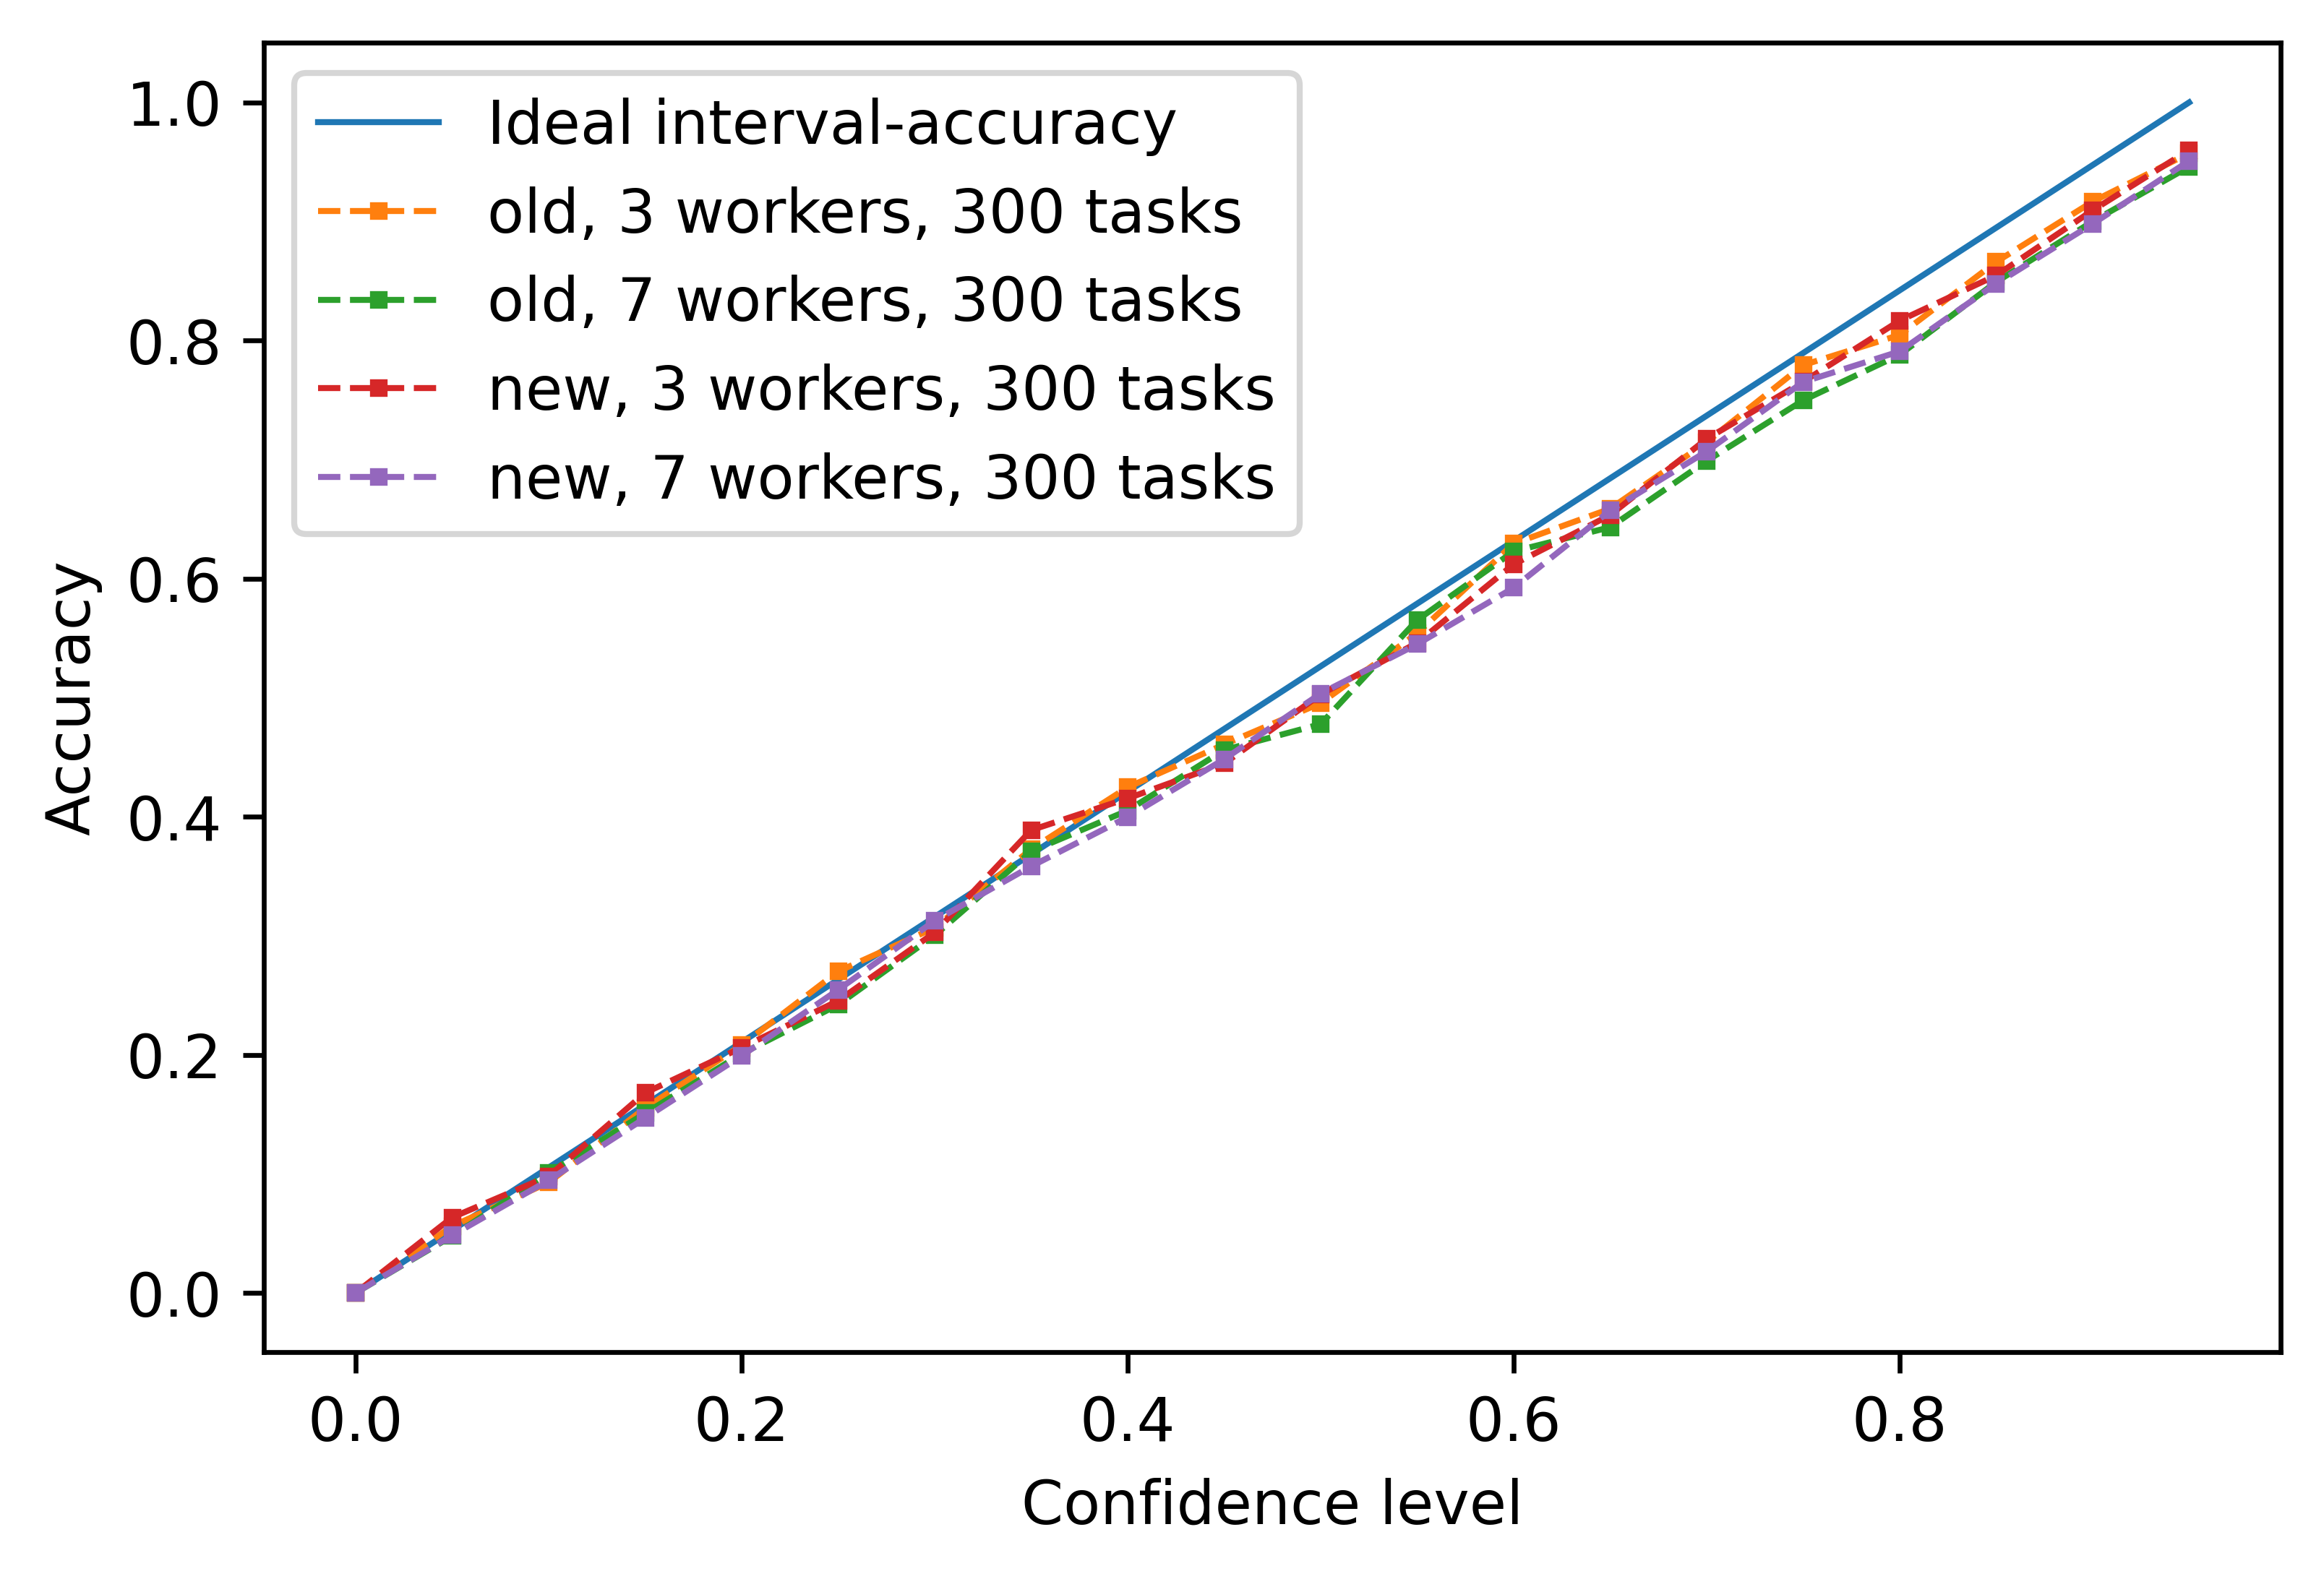

In [7]:
mpl.rcParams['figure.dpi'] = 600

plt.plot(confidence_levels, np.linspace(0, 1, len(confidence_levels)), label='Ideal interval-accuracy', linewidth=1)
for t in evaluater_names:
    for m, n in configurations:
        # n: num_samples
        # m: num_workers
        plt.plot(confidence_levels, accuracies[(n,m)][t], marker='s', linestyle='--',
             label = t+', '+str(m)+' workers, '+str(n)+' tasks', linewidth=1, markersize=2)

plt.xlabel('Confidence level')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# plt.savefig('confidence_vs_accuracy.svg')